# Question 5: SOM

# Importing Dependecies

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sys

import os
import time
import torch
import argparse
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

# Loading Dataset

In [ ]:
# Load dataset with labels
raw_data = datasets.FashionMNIST('data/', train=True, download=True).data.numpy().astype(float)
test_data = raw_data[1000:1300]

In [ ]:
initial_weight = np.random.rand(28*28*(15*15)).reshape(28*28, 15*15)

In [ ]:
raw_data = raw_data[:1000]

In [ ]:
raw_data = raw_data.reshape(1000,28*28)
test_data = test_data.reshape(300,28*28)

In [ ]:
# Number of neurons (1-dimensional)
M = 225

# Dimension of the input patterns
N = raw_data.shape[1]

# Total number of input patterns
P = raw_data.shape[0]

learning_rate = 0.3

R = 1

MAX_EPOCHS = 100

MAX_WEIGHT_DIFF = 0.0001

DECAY_FACTOR = 0.0001

RADIUS_REDUCTION_STEP = 200

np.set_printoptions(threshold=sys.maxsize)

## Pre-processing

In [ ]:
# Normalize input vectors
sc = MinMaxScaler(feature_range = (0, 1))
data = sc.fit_transform(raw_data)
test_data = sc.transform(test_data)


# Training

In [ ]:
# Step 1: Initialization of each node’s weights with a random number between 0 and 1
#weight = 0.1 * np.random.rand(N,M)
weight = np.copy(initial_weight)
#print("Initial weights:")
#print(np.around(weight, 2))

last_weight = np.copy(weight)
weights_history =[]
weights_history.append(last_weight)
for epoch in range(MAX_EPOCHS):
    print("\r\nEpoch:", epoch)
    print("Learning rate:", np.around(learning_rate, 6))
    print("Neighborhood radius:", R)
    
    # Step 2: Choosing input patterns ordering
    # use normal ordering
    pattern_ordering = np.arange(P)
    # use random ordering
    #np.random.shuffle(pattern_ordering)
    #print("Random input patterns ordering:", pattern_ordering)
    
    progress = 0
    
    # For each input pattern do the steps 3-5
    for p in pattern_ordering:
        
        progress = progress + 1
        
        #print("\r\n\tCurrent pattern index is", p, "and", np.around(progress/P*100, 2), "% of patterns has been processed in Epoch", epoch)
        
        # Step 3: Calculating the Best Matching Unit (BMU)

        # initialize distance vector
        distance_vector = np.zeros(M)
    
        # calculate distance of each weight from each input pattern
        for j in range(M):
            for i in range(N):
                distance_vector[j] = distance_vector[j] + (weight[i,j] - data[p,i])**2
                
        #print("\tdistance_vector", np.around(distance_vector, 2))

        # Step 4: find index j such that distance_vector[j] is a minimum
        min_distance_index = np.argmin(distance_vector)
        
        #print("\tmin_distance_index", min_distance_index)
        
        # Step 5: Update weights for all units j within a specified neighberhood of min_distance_index and for all i
        # calculate neighborhood borders
        begin_j = min_distance_index - R
        if (begin_j < 0):
            begin_j = 0
        
        end_j = min_distance_index + R
        if (end_j > M - 1):
            end_j = M - 1
            
        #print("neighberhood", begin_j, end_j)
        
        for j in range(begin_j, end_j + 1):
            for i in range(N):
                weight[i,j] = weight[i,j] + learning_rate * (data[p,i] - weight[i,j])

    # Step 6: Update learning rate
    learning_rate = DECAY_FACTOR * learning_rate

    # Step 7: Reduce radius of topological neighborhood at specified times
    if (epoch % RADIUS_REDUCTION_STEP):
        if R > 0 :
            R = R - 1
        
    # Step 8: Test stopping condition
    weight_diff = np.amax(np.abs(weight - last_weight))
    
    if (weight_diff < MAX_WEIGHT_DIFF):
        print("Weight change:", weight_diff, "<", MAX_WEIGHT_DIFF)
        print("Stopping condition is satisfied!")
        break
    else:
        print("Weight change:", weight_diff, ">", MAX_WEIGHT_DIFF)
    
    last_weight = np.copy(weight)
    weights_history.append(last_weight)

    # end of for loop


Epoch: 0
Learning rate: 0.3
Neighborhood radius: 1
Weight change: 0.9995507571793345 > 0.0001

Epoch: 1
Learning rate: 3e-05
Neighborhood radius: 1
Weight change: 0.0034967576816120616 > 0.0001

Epoch: 2
Learning rate: 0.0
Neighborhood radius: 0
Weight change: 1.2292408380076836e-07 < 0.0001
Stopping condition is satisfied!


In [ ]:
# associate pattern indices with clusters numbers
patterns_with_clusters = np.zeros((P, 2), dtype=int)

for p in range(300):

    distance_vector = np.zeros(M)

    # calculate distance of each weight from each input pattern
    for j in range(M):
        for i in range(N):
            distance_vector[j] = distance_vector[j] + (weight[i,j] - test_data[p,i])**2

    # find index j such that distance_vector[j] is a minimum
    min_distance_index = np.argmin(distance_vector)
    
    # store pattern index 
    patterns_with_clusters[p,0] = p
    # store cluster number associated with pattern 
    patterns_with_clusters[p,1] = min_distance_index

In [ ]:
# make an array of clusters size and members
clusters_size = [0 for j in range(M)]
clusters_members = [[] for j in range(M)]
for p in range(300):
    # increment cluster size by 1
    clusters_size[patterns_with_clusters[p,1].astype(int)] = clusters_size[patterns_with_clusters[p,1].astype(int)] + 1
    # append the pattern index to cluster members list
    clusters_members[patterns_with_clusters[p,1].astype(int)].append(p)


clustered_patterns = [clusters_size, clusters_members]

# find 20 largest clusters
largest_clusters = np.asarray(clusters_size).argsort()[-20:][::-1]

print("20 Largest Clusters")
total_of_20 = 0
for j in largest_clusters:
    print("Cluster", j, "\t=>\t", clusters_size[j],"patterns.")
    total_of_20 = total_of_20 + clusters_size[j]
print("\r\nTotal", total_of_20, "patterns are in top 20 clusters.")

20 Largest Clusters
Cluster 145 	=>	 44 patterns.
Cluster 147 	=>	 23 patterns.
Cluster 151 	=>	 20 patterns.
Cluster 152 	=>	 18 patterns.
Cluster 141 	=>	 18 patterns.
Cluster 146 	=>	 17 patterns.
Cluster 153 	=>	 15 patterns.
Cluster 137 	=>	 12 patterns.
Cluster 149 	=>	 12 patterns.
Cluster 144 	=>	 11 patterns.
Cluster 157 	=>	 10 patterns.
Cluster 136 	=>	 10 patterns.
Cluster 140 	=>	 10 patterns.
Cluster 142 	=>	 10 patterns.
Cluster 156 	=>	 8 patterns.
Cluster 139 	=>	 8 patterns.
Cluster 155 	=>	 7 patterns.
Cluster 154 	=>	 7 patterns.
Cluster 138 	=>	 7 patterns.
Cluster 158 	=>	 7 patterns.

Total 274 patterns are in top 20 clusters.


# Part B

In [ ]:
import seaborn as sns
clusters = np.asarray(clusters_size)

<BarContainer object of 225 artists>

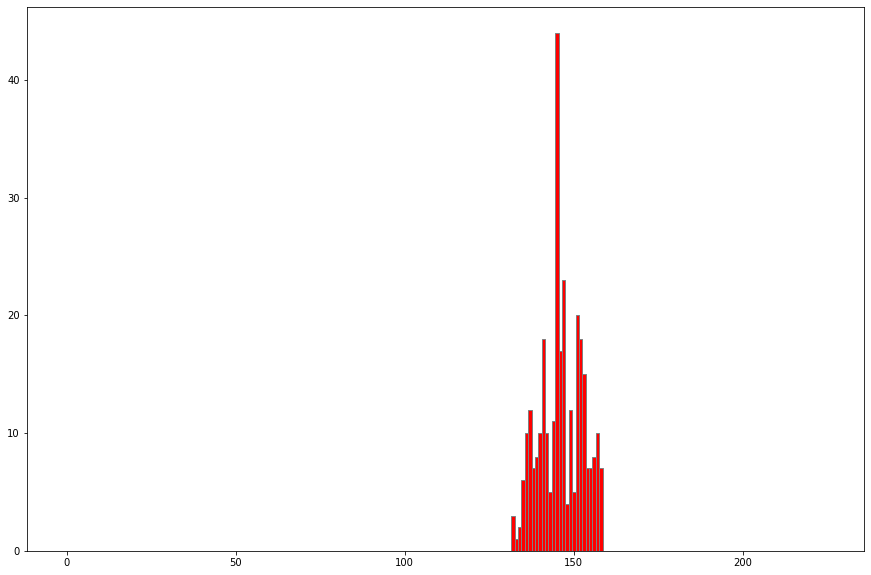

In [ ]:
# Set position of bar on X axis
br1 = np.arange(len(clusters))
 
# Make the plot
plt.figure(figsize=(15,10))
plt.bar(br1, clusters, color ='r', width = 1,
        edgecolor ='grey', label ='IT')


In [ ]:
last_weight.shape

(784, 225)